## My First Model, Let's import the required libraries

In [ ]:
pip install tensorflow

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Create some useful constants for later on

In [84]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

### Let's load the images from our image directory as tensorflow dataset

In [85]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./Potato_Images", 
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [86]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

### And have a look on the images, and their classes

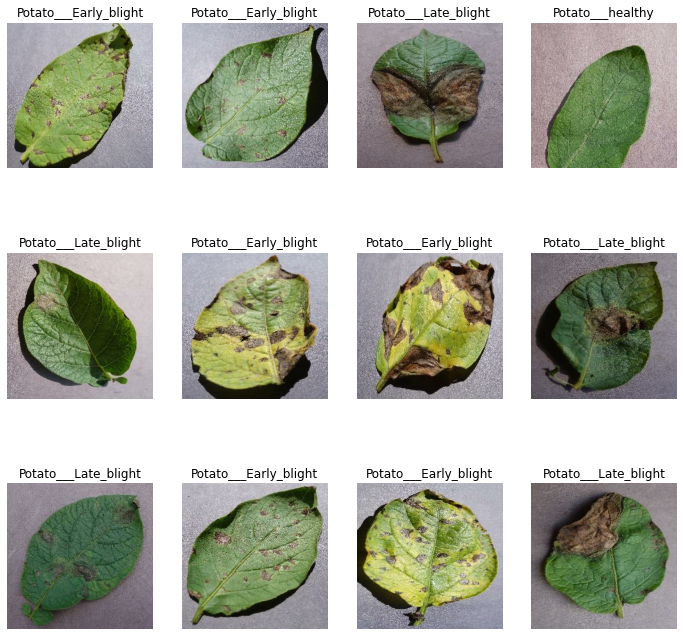

In [87]:
plt.figure(figsize=(12, 12))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### Divide our dataset into 3 parts, the training, the valuation while training, and the testing.

In [89]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds, test_ds

In [90]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

### Cache the data for better performance

In [91]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Load the image required models

We need to resize all the images to the same size,

and then rescale their rgb values so it will be between 0 and 1.

In [92]:
resize_and_rescale_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Augmentate the data
to create more diversity in our images and better predictions for our model

In [93]:
data_augmentation_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [99]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 3

## Building the model, 
### using a CNN with multiple convolution and pooling layers for better features detection


In [102]:
model = models.Sequential([
    resize_and_rescale_layer,
    data_augmentation_layer,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [103]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_21 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_83 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_83 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_84 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_84 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                

### Compile and train the model

In [104]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [105]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
54/54 [==============================] - 67s 1s/step - loss: 0.9174 - accuracy: 0.4919 - val_loss: 0.8753 - val_accuracy: 0.4844
Epoch 2/50
54/54 [==============================] - 59s 1s/step - loss: 0.8483 - accuracy: 0.6117 - val_loss: 0.7106 - val_accuracy: 0.7083
Epoch 3/50
54/54 [==============================] - 59s 1s/step - loss: 0.6536 - accuracy: 0.7488 - val_loss: 0.6257 - val_accuracy: 0.7448
Epoch 4/50
54/54 [==============================] - 60s 1s/step - loss: 0.5235 - accuracy: 0.8044 - val_loss: 0.5526 - val_accuracy: 0.7604
Epoch 5/50
54/54 [==============================] - 57s 1s/step - loss: 0.4457 - accuracy: 0.8218 - val_loss: 0.5982 - val_accuracy: 0.7708
Epoch 6/50
54/54 [==============================] - 58s 1s/step - loss: 0.3399 - accuracy: 0.8634 - val_loss: 0.2948 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 59s 1s/step - loss: 0.3206 - accuracy: 0.8681 - val_loss: 0.3421 - val_accuracy: 0.9010
Epoch 8/50
54/54 [==

### Lets have a look at our results

In [117]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

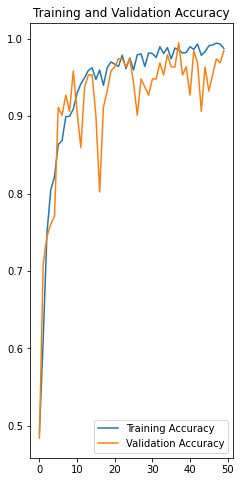

In [118]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

### And lastly, let's test our model :)

In [124]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

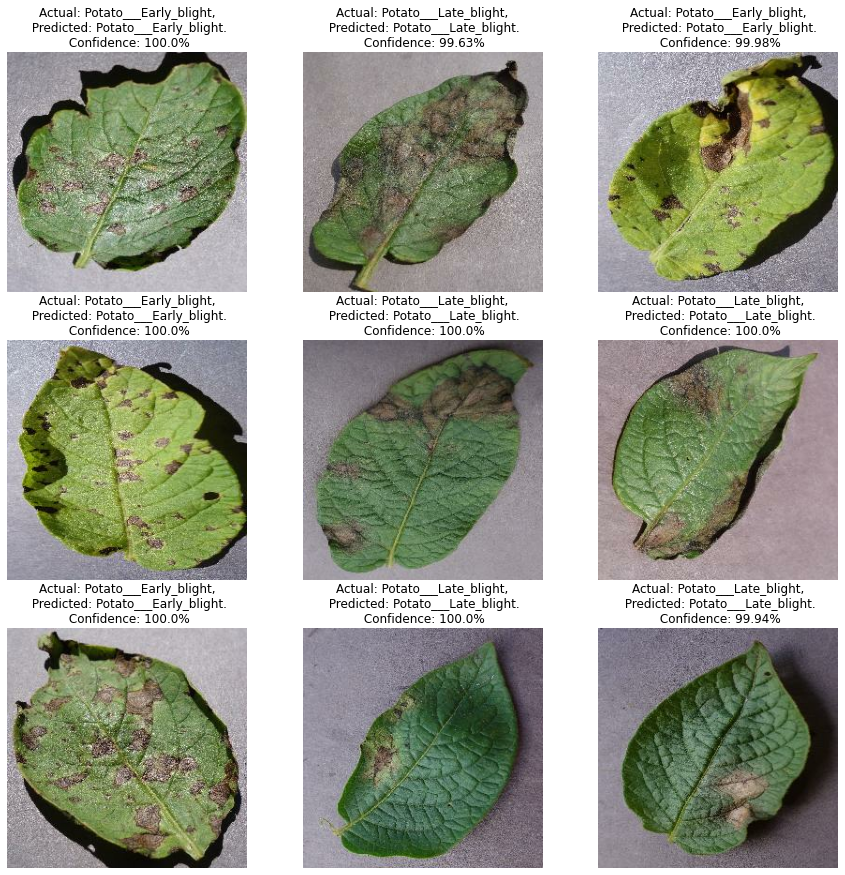

In [125]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [130]:
model.save("./potatoes.h5", save_format='h5')